In [11]:
#load the necessary modules
import numpy as np
import matplotlib.pyplot as plt
import random as rn
import time as t
from tqdm import tqdm

In [12]:
def grid_maker_tri(nrows,ncols):
  '''
  This function generates a random classical triangular grid of any size

  Parameters:

  - nrows: (integer) Specify the number of rows
  - ncols: (integer) Specify the number of columns

  Returns:

  The function returns your desired random grid of any size.

  '''
  if not isinstance(nrows, int) or nrows <= 0:
    raise ValueError("nrows must be a positive integer")
  if not isinstance(ncols, int) or ncols <= 0:
    raise ValueError("nrows must be a positive integer")

  grid_points = np.zeros((nrows,ncols))

  for i in range(nrows):
    for j in range(ncols):
      grid_points[i,j] = rn.choice([-1,1])

  return grid_points

In [13]:
def compute_energy_triangular(grid, mag = 'f'):
    """
    This function calculates the energy of a 2D triangular lattice with classical spins
    (Implements periodic boundary conditions).

    Parameters:
    - grid: input a 2D grid
    - mag: 'f' or 'af' to select between ferromagnetic calculation or anti-ferromagnetic calculations respectively
           (By default it is set in ferromagnetic('f') state)
    Returns:
    - Energy of the lattice
    """
    energy = 0
    nrows, ncols = grid.shape

    if mag == 'f':

        for k in range(nrows):
            for l in range(ncols):
                for dk, dl in [[0, -1], [0, 1], [-1, 0], [1, 0],[1,-1],[-1,1]]:
                    ni, nj = (k + dk) % nrows, (l + dl) % ncols #implementation of periodic boundary conditions
                    energy += -grid[k, l] * grid[ni, nj]

    elif mag == 'af':

        for k in range(nrows):
            for l in range(ncols):
                for dk, dl in [[0, -1], [0, 1], [-1, 0], [1, 0],[1,-1],[-1,1]]:
                    ni, nj = (k + dk) % nrows, (l + dl) % ncols #implementation of periodic boundary conditions
                    energy += grid[k, l] * grid[ni, nj]

    return energy / 2

In [14]:
def ising_model_triangular(nsamples, temperature, grid_points, mag = 'f'):
    """
    This function runs the Ising model simulation using Metropolis-Hastings for a 2D triangular lattice.
    (Implements periodic boundary condition)

    Parameters:
    - nsamples: Number of samples to be taken.
    - temperature: Temperature at which the system is simulated.
    - grid_points: Takes a grid of any size.
    - mag: 'f' or 'af' to select between ferromagnetic calculation or anti-ferromagnetic calculations respectively
           (By default it is set in ferromagnetic('f') state)

    Returns:
    - saved_energies: List of sampled energies by burning the first 20% of the sampled energies.
    - grid_points: The final grid after simulation.
    """
    if temperature <= 0:
        raise ValueError("Temperature must be positive.")

    saved_energies = []

    nrows, ncols = grid_points.shape

    for n in range(nsamples):
        i, j = np.random.randint(0, nrows), np.random.randint(0, ncols)
        temp_grid = np.copy(grid_points)
        temp_grid[i, j] = -temp_grid[i, j]

        energy = compute_energy_triangular(grid_points, mag)
        temp_energy = compute_energy_triangular(temp_grid, mag)
        energy_diff = temp_energy - energy

        p_acceptance = np.exp(-energy_diff / temperature) if temperature > 0 else 0

        if energy_diff < 0 or np.random.rand() < p_acceptance:
            grid_points[i, j] = -grid_points[i, j]
            saved_energies.append(temp_energy)
        else:
            saved_energies.append(energy)

    return saved_energies[int(nsamples/5):], grid_points


In [15]:
def specific_heat_triangular(grid, temp_range, nsamples=10000, mag = 'f'):
    """
    This function calculates and gives a list of specific heat for a lattice across a given temperature range
   (Implements periodic boundary condition)

    NOTE: Function returns 2 lists. Use 2 variables while calling the function.
    Parameters:
    - grid: Initial 2D Ising spin configuration.
    - temp_range: List of temperatures.
    - nsamples: Number of Monte Carlo samples per temperature.
    - mag: 'f' or 'af' to select between ferromagnetic calculation or anti-ferromagnetic calculations respectively
           (By default it is set in ferromagnetic('f') state)

    Returns:
    - Cv: List of specific heat values.
    - updated_Cv: Filtered Cv list without NaN values.
    """
    energy_collections = []

    print("******************************************************")
    print("Collecting energies. Kindly wait.")
    print("****************************************************** \n")

    for t in tqdm(temp_range, desc='collecting energies', unit='iterations'):
        energy, grid = ising_model_triangular(nsamples, temperature=t, grid_points=grid, mag=mag)
        energy_collections.append(energy)

    print("******************************************************")
    print("Energy collection completed! Calculating Cv now.")
    print("****************************************************** \n")

    Cv = []
    for t, energies in zip(temp_range, energy_collections):
        var_energy = np.var(energies)
        Cv.append(var_energy / (t**2))

    print("******************************************************")
    print("Cv has been calculated. Refining it to remove NaN values now.")
    print("****************************************************** \n")

    updated_Cv = [c for c in Cv if not np.isnan(c)]

    print("******************************************************")
    print("Your results are ready!")
    print("****************************************************** \n")

    return Cv, updated_Cv

In [16]:
def magnetize_triangular(grid, temp_range, nsweep=10000, mag='f'):
    '''
    This function calculates and gives a list of magnetization for a triangular lattice across a given temperature range.
    (Implements periodic boundary condition)

    Parameters:
    - grid: Takes a 2D grid of any size.
    - temp_range: List of temperatures for which magnetic susceptibility is to be calculated.
    - nsweep: Number of samples per temperature (default is 10000).
    - mag: 'f' or 'af' for ferromagnetic or anti-ferromagnetic calculations, respectively (default: 'f').

    Returns:
    - magnetization: A list of magnetization values across all temperatures.
    '''
    magnetization_values = []
    nrows, ncols = grid.shape
    N = nrows * ncols 

    for T in tqdm(temp_range, desc="Processing temperatures", unit="temperature"):
        magnetizations = []  

        for _ in range(nsweep):
            _, grid = ising_model_triangular(nsamples=1, temperature=T, grid_points=grid, mag=mag)
            magnetizations.append(abs(np.sum(grid)) / N)  

        magnetization_values.append(np.mean(magnetizations))

    return magnetization_values


In [17]:
def mag_susceptibility_triangular(grid, temp_range, mag = 'f', nsweep=10000):
    '''
    This function calculates the magnetic susceptibility for a triangular lattice across a given temperature range.
    (Implements periodic boundary condition)
    Parameters:
    - grid: Takes a 2D grid of any size.
    - temp_range: A list of temperatures at which susceptibility is calculated.
    - mag: 'f' or 'af' to select between ferromagnetic calculation or anti-ferromagnetic calculations respectively
           (By default it is set in ferromagnetic('f') state)
    - nsweep: How many times would you like to sample the configuration at a given temperature
                (default is 10000).
    Returns:
    - A list of calculated magnetic susceptibilities.
    '''

    susceptibility_values = []

    print("******************************************************")
    print("Collecting magnetization data. Kindly wait.")
    print("****************************************************** \n")

    for T in tqdm(temp_range, desc="Processing temperatures", unit="temperature"):
        magnetizations = []

        for _ in range(nsweep):
            energy, grid = ising_model_triangular(nsamples=1, temperature=T, grid_points=grid, mag=mag)
            magnetization = np.sum(grid)
            magnetizations.append(magnetization)

        mean_M = np.mean(magnetizations)
        mean_M2 = np.mean(np.square(magnetizations))
        chi = (mean_M2 - mean_M**2) / T
        susceptibility_values.append(chi)

    print("******************************************************")
    print("Magnetic susceptibility calculation completed!")
    print("****************************************************** \n")
    return susceptibility_values

In [18]:
def mean_energy_triangular(grid, temp_range, nsamples=10000, mag='f'):
    '''
    This function calculates and gives a list of mean energy for a 2D triangular lattice across a given temperature range
    (Implements periodic boundary conditions)

    Parameters taken:

    - grid: Takes a 2D grid of any size.
    - temp_range: Takes a list of temperatures for which mean energy is to be calculated.
    - nsamples: How many times would you like to sample the configuration at a given temperature
                (default is 10000).
    - mag: 'f' or 'af' to select between ferromagnetic calculation or anti-ferromagnetic calculations respectively
           (By default it is set in ferromagnetic('f') state)
    Returns:

    - mean_energies: A list of calculated mean energy.
    '''
    energy_collections = []
    nrows, ncols = grid.shape
    grid = grid
    print("******************************************************")
    print("Collecting energies. Kindly wait.")
    print("****************************************************** \n")

    for t in tqdm(temp_range, desc='collecting energies', unit='temperature'):
        energy, grid = ising_model_triangular(nsamples, temperature=t, grid_points=grid, mag=mag)
        energy_collections.append(energy)

    mean_energies = []

    print("******************************************************")
    print("Energy collection completed! Calculating mean energy now.")
    print("****************************************************** \n")

    for i in tqdm(energy_collections, desc='calculating mean energy', unit='energy sample'):
        mean_energies.append(np.mean(i))

    print("******************************************************")
    print("Your results are ready!")
    print("****************************************************** \n")

    return mean_energies


In [32]:
grid = grid_maker_tri(10,10)
temp_range = np.linspace(0.5,7,100)

In [20]:
Cv_tri, updated_Cv_tri = specific_heat_triangular(grid, temp_range, mag='af', nsamples=75000)
Cv1_tri, updated_Cv1_tri = specific_heat_triangular(grid, temp_range, mag='f', nsamples=75000)

******************************************************
****************************************************** 



collecting energies: 100%|██████████| 100/100 [40:59<00:00, 24.60s/iterations]


******************************************************
Energy collection completed! Calculating Cv now.
****************************************************** 

******************************************************
Cv has been calculated. Refining it to remove NaN values now.
****************************************************** 

******************************************************
Your results are ready!
****************************************************** 

******************************************************
****************************************************** 



collecting energies: 100%|██████████| 100/100 [44:04<00:00, 26.44s/iterations]


******************************************************
Energy collection completed! Calculating Cv now.
****************************************************** 

******************************************************
Cv has been calculated. Refining it to remove NaN values now.
****************************************************** 

******************************************************
Your results are ready!
****************************************************** 



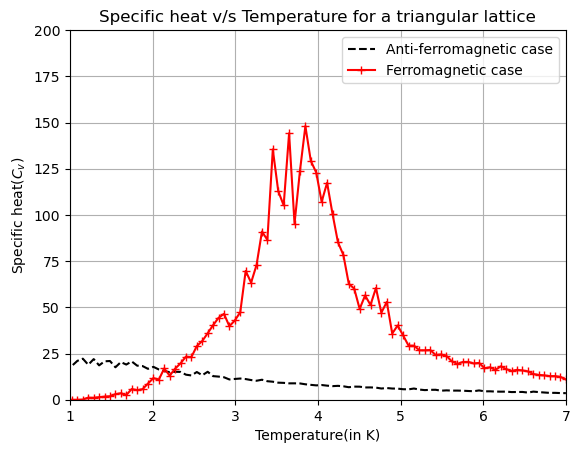

In [21]:
plt.plot(temp_range, Cv_tri, 'k--', label='Anti-ferromagnetic case')
plt.plot(temp_range, Cv1_tri, 'r+-', label='Ferromagnetic case')
plt.xlabel('Temperature(in K)')
plt.ylabel(r'Specific heat($C_v$)')
plt.title("Specific heat v/s Temperature for a triangular lattice")
plt.xlim(1,7)
plt.ylim(0,200)
plt.legend()
plt.grid()

In [22]:
mean_en_tri = mean_energy_triangular(grid, temp_range, mag='af', nsamples=75000)
mean_en1_tri = mean_energy_triangular(grid, temp_range, mag='f', nsamples=75000)

******************************************************
****************************************************** 



collecting energies: 100%|██████████| 100/100 [41:17<00:00, 24.77s/temperature]


******************************************************
Energy collection completed! Calculating mean energy now.
****************************************************** 



calculating mean energy: 100%|██████████| 100/100 [00:00<00:00, 467.86energy sample/s]


******************************************************
Your results are ready!
****************************************************** 

******************************************************
****************************************************** 



collecting energies: 100%|██████████| 100/100 [43:52<00:00, 26.32s/temperature]


******************************************************
Energy collection completed! Calculating mean energy now.
****************************************************** 



calculating mean energy: 100%|██████████| 100/100 [00:00<00:00, 463.81energy sample/s]

******************************************************
Your results are ready!
****************************************************** 



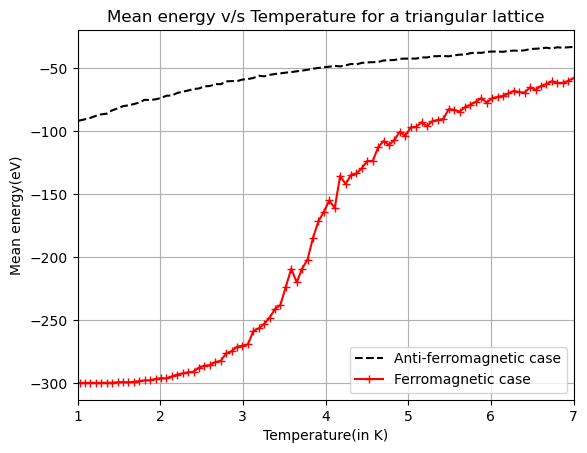

In [23]:
plt.plot(temp_range, mean_en_tri, 'k--', label='Anti-ferromagnetic case')
plt.plot(temp_range, mean_en1_tri, 'r+-', label='Ferromagnetic case')
plt.xlabel('Temperature(in K)')
plt.ylabel(r'Mean energy(eV)')
plt.title("Mean energy v/s Temperature for a triangular lattice")
plt.xlim(1,7)
plt.legend()
plt.grid()

In [24]:
magnetize_tri = magnetize_triangular(grid, temp_range, mag='af', nsweep=75000)
magnetize1_tri = magnetize_triangular(grid, temp_range, mag='f', nsweep=75000)

Processing temperatures: 100%|██████████| 100/100 [44:43<00:00, 26.84s/temperature]


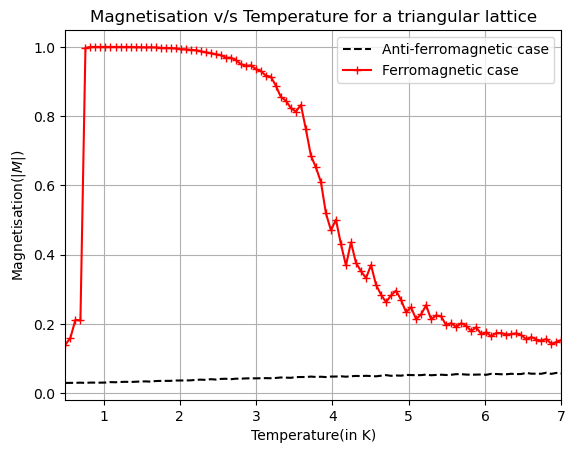

In [25]:
plt.plot(temp_range, np.abs(magnetize_tri), 'k--', label='Anti-ferromagnetic case')
plt.plot(temp_range, magnetize1_tri, 'r+-', label='Ferromagnetic case')
plt.xlabel('Temperature(in K)')
plt.ylabel(r'Magnetisation($|M|$)')
plt.title("Magnetisation v/s Temperature for a triangular lattice")
plt.xlim(0.5,7)
plt.legend()
plt.grid()

In [26]:
X_tri = mag_susceptibility_triangular(grid, temp_range, mag='af', nsweep=75000)
X1_tri = mag_susceptibility_triangular(grid, temp_range, mag='f', nsweep=75000)

******************************************************
****************************************************** 



Processing temperatures: 100%|██████████| 100/100 [41:53<00:00, 25.13s/temperature]


******************************************************
Magnetic susceptibility calculation completed!
****************************************************** 

******************************************************
****************************************************** 



Processing temperatures: 100%|██████████| 100/100 [44:53<00:00, 26.94s/temperature]

******************************************************
Magnetic susceptibility calculation completed!
****************************************************** 



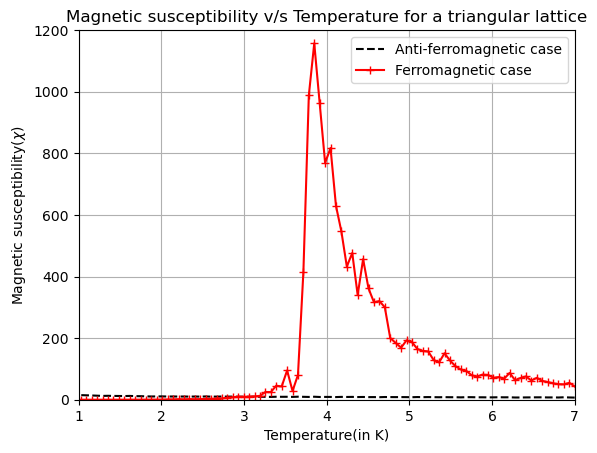

In [27]:
plt.plot(temp_range, X_tri, 'k--', label='Anti-ferromagnetic case')
plt.plot(temp_range, X1_tri, 'r+-', label='Ferromagnetic case')
plt.xlabel('Temperature(in K)')
plt.ylabel(r'Magnetic susceptibility($\chi$)')
plt.title("Magnetic susceptibility v/s Temperature for a triangular lattice")
plt.xlim(1,7)
plt.ylim(0,1200)
plt.legend()
plt.grid()

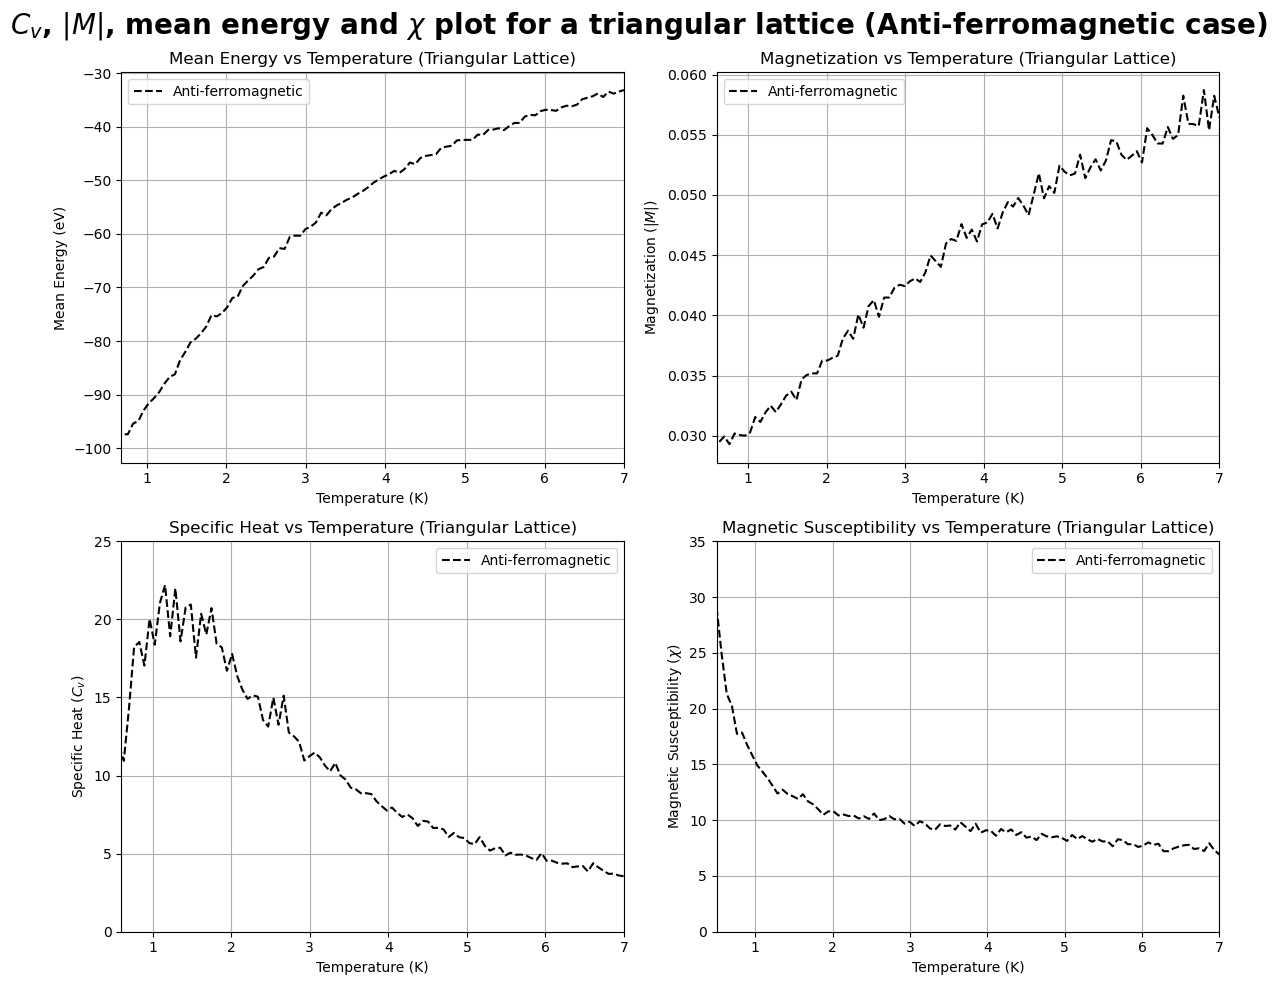

In [41]:
fig2, axes2 = plt.subplots(2, 2, figsize=(12, 10))

axes2[1, 0].plot(temp_range, Cv_tri, 'k--', label='Anti-ferromagnetic')
axes2[1, 0].set_xlabel("Temperature (K)")
axes2[1, 0].set_ylabel(r"Specific Heat ($C_v$)")
axes2[1, 0].set_title("Specific Heat vs Temperature (Triangular Lattice)")
axes2[1, 0].set_xlim(0.6, 7)
axes2[1, 0].set_ylim(0, 25)
axes2[1, 0].grid()
axes2[1, 0].legend()

axes2[0, 0].plot(temp_range, mean_en_tri, 'k--', label='Anti-ferromagnetic')
axes2[0, 0].set_xlabel("Temperature (K)")
axes2[0, 0].set_ylabel("Mean Energy (eV)")
axes2[0, 0].set_title("Mean Energy vs Temperature (Triangular Lattice)")
axes2[0, 0].set_xlim(0.68, 7)
axes2[0, 0].grid()
axes2[0, 0].legend()

axes2[0, 1].plot(temp_range, magnetize_tri, 'k--', label='Anti-ferromagnetic')
axes2[0, 1].set_xlabel("Temperature (K)")
axes2[0, 1].set_ylabel(r"Magnetization ($|M|$)")
axes2[0, 1].set_title("Magnetization vs Temperature (Triangular Lattice)")
axes2[0, 1].set_xlim(0.6, 7)
axes2[0, 1].grid()
axes2[0, 1].legend()

axes2[1, 1].plot(temp_range, X_tri, 'k--', label='Anti-ferromagnetic')
axes2[1, 1].set_xlabel("Temperature (K)")
axes2[1, 1].set_ylabel(r"Magnetic Susceptibility ($\chi$)")
axes2[1, 1].set_title("Magnetic Susceptibility vs Temperature (Triangular Lattice)")
axes2[1, 1].set_xlim(0.5, 7)
axes2[1, 1].set_ylim(0, 35)
axes2[1, 1].grid()
axes2[1, 1].legend()
fig2.suptitle(r"$C_v$, $|M|$, mean energy and $\chi$ plot for a triangular lattice (Anti-ferromagnetic case)", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

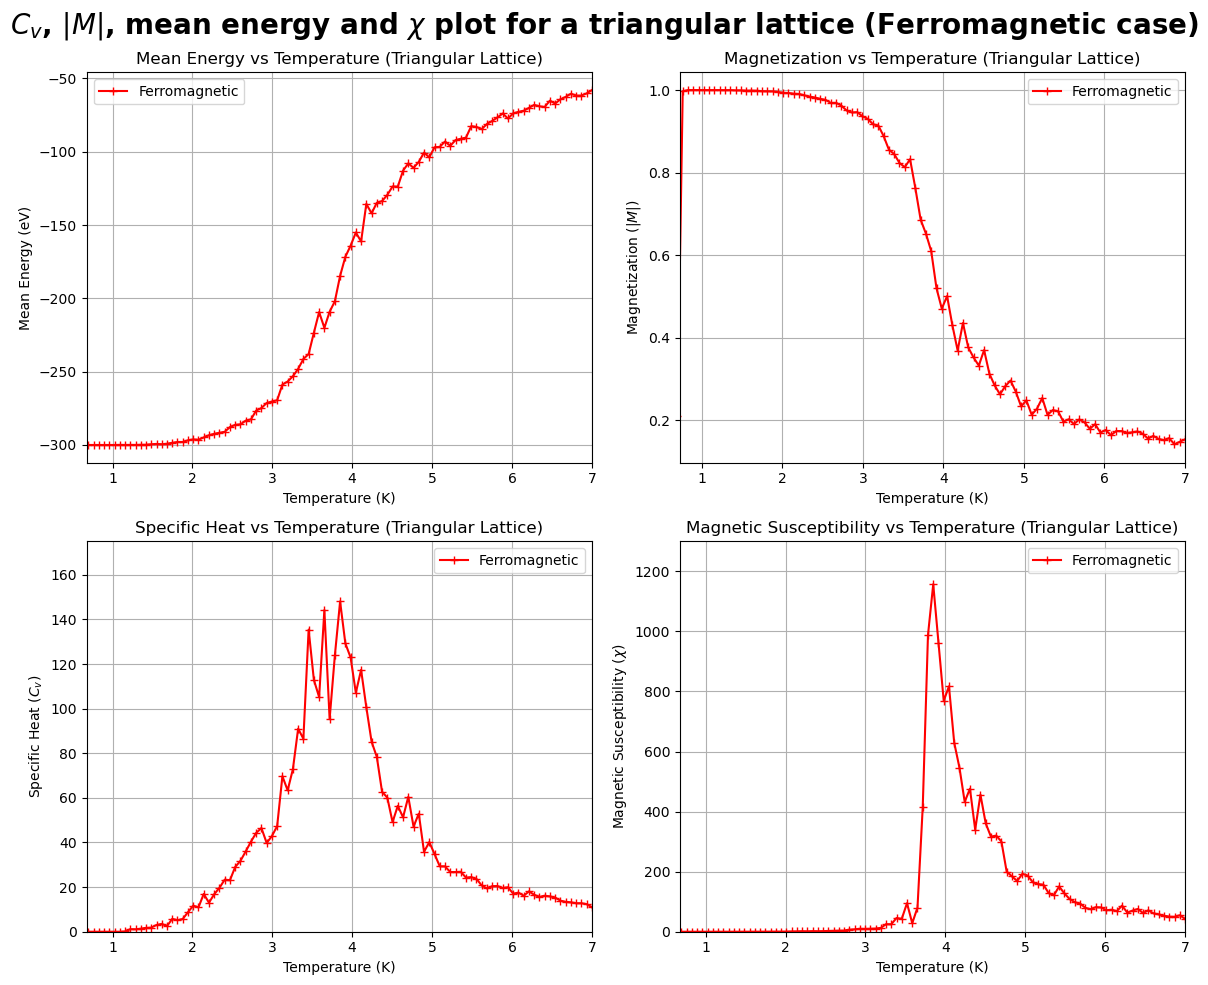

In [43]:
fig2, axes2 = plt.subplots(2, 2, figsize=(12, 10))

axes2[1, 0].plot(temp_range, Cv1_tri, 'r+-', label='Ferromagnetic')
axes2[1, 0].set_xlabel("Temperature (K)")
axes2[1, 0].set_ylabel(r"Specific Heat ($C_v$)")
axes2[1, 0].set_title("Specific Heat vs Temperature (Triangular Lattice)")
axes2[1, 0].set_xlim(0.68, 7)
axes2[1, 0].set_ylim(0, 175)
axes2[1, 0].grid()
axes2[1, 0].legend()

axes2[0, 0].plot(temp_range, mean_en1_tri, 'r+-', label='Ferromagnetic')
axes2[0, 0].set_xlabel("Temperature (K)")
axes2[0, 0].set_ylabel("Mean Energy (eV)")
axes2[0, 0].set_title("Mean Energy vs Temperature (Triangular Lattice)")
axes2[0, 0].set_xlim(0.68, 7)
axes2[0, 0].grid()
axes2[0, 0].legend()

axes2[0, 1].plot(temp_range, magnetize1_tri, 'r+-', label='Ferromagnetic')
axes2[0, 1].set_xlabel("Temperature (K)")
axes2[0, 1].set_ylabel(r"Magnetization ($|M|$)")
axes2[0, 1].set_title("Magnetization vs Temperature (Triangular Lattice)")
axes2[0, 1].set_xlim(0.73, 7)
axes2[0, 1].grid()
axes2[0, 1].legend()

axes2[1, 1].plot(temp_range, X1_tri, 'r+-', label='Ferromagnetic')
axes2[1, 1].set_xlabel("Temperature (K)")
axes2[1, 1].set_ylabel(r"Magnetic Susceptibility ($\chi$)")
axes2[1, 1].set_title("Magnetic Susceptibility vs Temperature (Triangular Lattice)")
axes2[1, 1].set_xlim(0.68, 7)
axes2[1, 1].set_ylim(0, 1300)

axes2[1, 1].grid()
axes2[1, 1].legend()
fig2.suptitle(r"$C_v$, $|M|$, mean energy and $\chi$ plot for a triangular lattice (Ferromagnetic case)", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

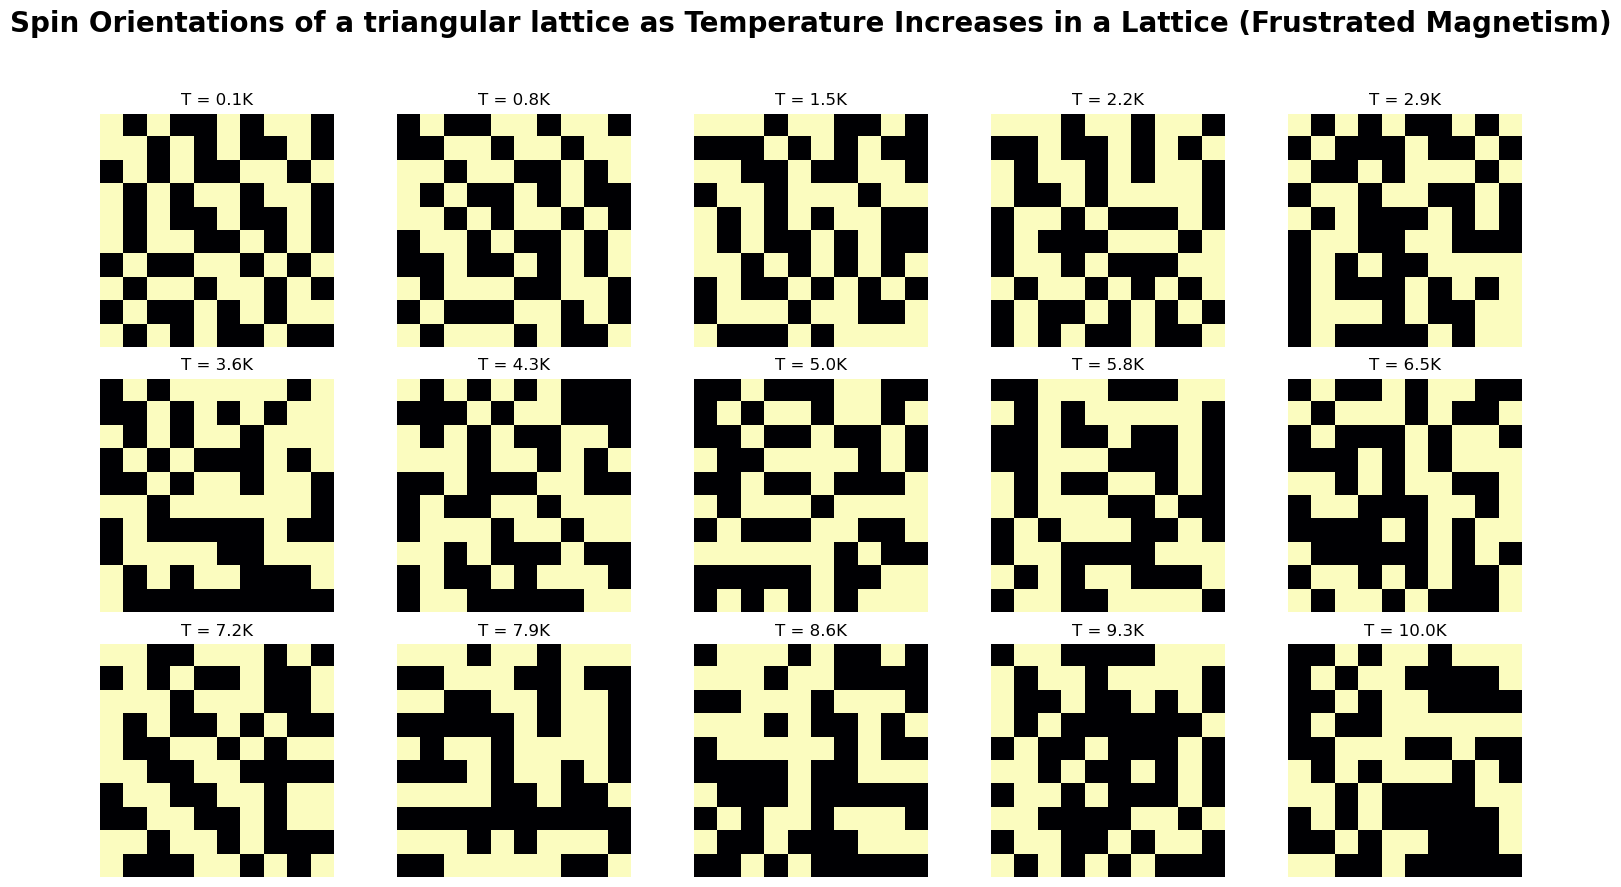

In [30]:
temp_range = np.linspace(0.1, 10, 15)

fig, axes = plt.subplots(3, 5, figsize=(15, 9))

for idx, temp in enumerate(temp_range):
    energy, grid = ising_model_triangular(nsamples=50000, temperature=temp, grid_points=grid, mag='af')

    ax = axes[idx // 5, idx % 5]
    ax.imshow(grid, cmap="magma")
    ax.set_title(f"T = {temp:.1f}K", fontsize=12)
    ax.axis("off")

fig.suptitle("Spin Orientations of a triangular lattice as Temperature Increases in a Lattice (Frustrated Magnetism)", fontsize=20, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()